Just download some basic module we have to use in this project(fastai.api)

In [1]:
# Make sure Runtime > Change runtime type is set to GPU

# Setup
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()
from fastbook import *
from fastai.text.all import *

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 25.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 48.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
Mounted at /content/gdrive


In [2]:
# Find the news category on my google drive
import os
os.listdir( "gdrive/MyDrive/EAI6010" )

['NewsCategory_v2.zip']

In [3]:
# Unzip the data set
!unzip "gdrive/MyDrive/EAI6010/NewsCategory_v2.zip"
print( "\n\n" )
os.listdir( )

Archive:  gdrive/MyDrive/EAI6010/NewsCategory_v2.zip
   creating: NewsCategory_v2/
  inflating: NewsCategory_v2/source.txt  
  inflating: NewsCategory_v2/News_Category_Dataset_v2.json  
  inflating: __MACOSX/NewsCategory_v2/._News_Category_Dataset_v2.json  





['.config', 'gdrive', '__MACOSX', 'NewsCategory_v2', 'sample_data']

In [4]:
# Let's see what's in the extracted data
print( f"root directory:\n{os.listdir( 'NewsCategory_v2' )}" )

# Simple enough -- a single JSON document, let's load it and see what we have.

root directory:
['News_Category_Dataset_v2.json', 'source.txt']


In [5]:
# The JSON isn't a valid format -- load it by line first
with open( os.path.join( "NewsCategory_v2", "News_Category_Dataset_v2.json" ), "r" ) as f:
  record_lines = f.readlines( )

# ...then parse each line
import json
record_jsons = list( )
for record_line in record_lines:
  record_json = json.loads( record_line )
  record_jsons.append( record_json )

# Show the first record
print( f"first record:\n{record_jsons[ 2 ]}" )

# We have the article's headline, short description, & category. This format
# isn't very handy to use with the fast.ai libraries though -- we need to
# do some additional formatting.

first record:
{'category': 'ENTERTAINMENT', 'headline': 'Hugh Grant Marries For The First Time At Age 57', 'authors': 'Ron Dicker', 'link': 'https://www.huffingtonpost.com/entry/hugh-grant-marries_us_5b09212ce4b0568a880b9a8c', 'short_description': 'The actor and his longtime girlfriend Anna Eberstein tied the knot in a civil ceremony.', 'date': '2018-05-26'}


In [8]:
# Let's filter everything to a subset of the classes because language models
# are really really slow to train

# Collect the classes
categories = set( )
for record_json in record_jsons:
  categories.add( record_json[ 'category' ] )
print( f"num. categories: {len( categories )}\n\ncategories:\n{categories}" )

# Keep only the first categories -- you can tinker with this step to train the
# model on fewer-more categories
category_subset = list( categories )[ 10 : 20 ]
print( f"\ncategory subset:\n{category_subset}" )

num. categories: 41

categories:
{'PARENTING', 'MONEY', 'PARENTS', 'GREEN', 'BLACK VOICES', 'WOMEN', 'EDUCATION', 'HOME & LIVING', 'ENTERTAINMENT', 'WEDDINGS', 'FOOD & DRINK', 'ARTS & CULTURE', 'TASTE', 'COMEDY', 'RELIGION', 'HEALTHY LIVING', 'THE WORLDPOST', 'TECH', 'TRAVEL', 'FIFTY', 'GOOD NEWS', 'QUEER VOICES', 'IMPACT', 'WELLNESS', 'ENVIRONMENT', 'STYLE & BEAUTY', 'BUSINESS', 'WORLD NEWS', 'DIVORCE', 'CRIME', 'SPORTS', 'STYLE', 'COLLEGE', 'LATINO VOICES', 'CULTURE & ARTS', 'MEDIA', 'ARTS', 'POLITICS', 'WORLDPOST', 'WEIRD NEWS', 'SCIENCE'}

category subset:
['FOOD & DRINK', 'ARTS & CULTURE', 'TASTE', 'COMEDY', 'RELIGION', 'HEALTHY LIVING', 'THE WORLDPOST', 'TECH', 'TRAVEL', 'FIFTY']


In [9]:
# Let's follow the convention of a folder per class with single files per
# record

# Reset the root directory if we need to -- we check and delete so this code is repeatable
root_dir_name = "news_by_category"
print( f"setting up '{root_dir_name}'" )
if os.path.exists( root_dir_name ):
  shutil.rmtree( root_dir_name )
os.mkdir( root_dir_name )

# Initialize the counts for each of the subset
category_to_count = dict( )
for category in category_subset:
  category_to_count[ category ] = 0

# Create a file for each record and put it in a subfolder named for the category
count = 0
total_words = 0 # we need to set a sequence length for the language model, so we should capture the typical lengths of the documents
for record in record_jsons:

  # Skip this record if its not one of the categories we are interested in
  category = record[ "category" ]
  if category not in category_subset:
    continue

  # Update the processed count and show the progress if we should
  count = count + 1
  if ( count % 10000 ) == 0:
    print( f"creating file for record {int(count/1000)}k" )

  # Setup the directory if it doesn't exist
  dir_path = os.path.join( root_dir_name, category )
  if not os.path.exists( dir_path ):
    os.mkdir( dir_path )

  # Build the document text and save the word length
  document_text = f"{record[ 'headline' ]} \n {record[ 'short_description' ]} \n " # document content is the headline + short description
  total_words = total_words + len( document_text.split( " " ) )

  # Save the document text to file
  category_count = category_to_count[ category ] + 1
  category_to_count[ category ] = category_count
  filename = f"{category}-{category_count}.txt"
  file_path = os.path.join( dir_path, filename )
  with open( file_path, "w" ) as f:
    f.write( document_text )

# Verify the directories
print( f"\nworking directory:\n{os.listdir( )}" )
print( f"\ndata directory:\n{os.listdir( root_dir_name )}" )
category_dir_path = os.path.join( root_dir_name, category_subset[ 0 ] )
print( f"\n'{category_dir_path}'':\n{os.listdir( os.path.join( root_dir_name, category_subset[ 0 ] ) )}" )
category_dir_path = os.path.join( root_dir_name, category_subset[ 1 ] )
print( f"\n'{category_dir_path}'':\n{os.listdir( os.path.join( root_dir_name, category_subset[ 1 ] ) )}" )

# Verify a document
with open( os.path.join( category_dir_path, f"{category_subset[ 1 ]}-1.txt" ), 'r' ) as f:
  document_content = f.readlines( )
  print( f"\ndocument content:\n{document_content}" )

# Calculate the average document length so we can intelligently set the sequence length (predict the next word give the input sequence)
avg_document_words = round( total_words / count )
print( f"\naverage number of words in a document = {avg_document_words}")

setting up 'news_by_category'
creating file for record 10k
creating file for record 20k
creating file for record 30k
creating file for record 40k

working directory:
['.config', 'news_by_category', 'gdrive', '__MACOSX', 'NewsCategory_v2', 'sample_data']

data directory:
['TASTE', 'TRAVEL', 'THE WORLDPOST', 'TECH', 'RELIGION', 'COMEDY', 'FIFTY', 'ARTS & CULTURE', 'HEALTHY LIVING', 'FOOD & DRINK']

'news_by_category/FOOD & DRINK'':
['FOOD & DRINK-441.txt', 'FOOD & DRINK-1258.txt', 'FOOD & DRINK-4668.txt', 'FOOD & DRINK-1536.txt', 'FOOD & DRINK-3384.txt', 'FOOD & DRINK-3475.txt', 'FOOD & DRINK-151.txt', 'FOOD & DRINK-4799.txt', 'FOOD & DRINK-1230.txt', 'FOOD & DRINK-4795.txt', 'FOOD & DRINK-2980.txt', 'FOOD & DRINK-4957.txt', 'FOOD & DRINK-4610.txt', 'FOOD & DRINK-1060.txt', 'FOOD & DRINK-1419.txt', 'FOOD & DRINK-530.txt', 'FOOD & DRINK-1119.txt', 'FOOD & DRINK-2714.txt', 'FOOD & DRINK-5083.txt', 'FOOD & DRINK-222.txt', 'FOOD & DRINK-4476.txt', 'FOOD & DRINK-5857.txt', 'FOOD & DRINK-1153.

In [10]:
# Now that we have data in a format that is typical, let's get it ready to fine
# tune a language model

# First the data block to tell how normalize things -- there is caching
# happening in the data block -- if you change the directory content at all
# after this object is created, do a "Factory reset runtime" (Runtime menu) to
# fully reset the environment
language_model_block = DataBlock( # https://docs.fast.ai/data.block.html
  blocks = TextBlock.from_folder( root_dir_name, is_lm = True ), # read the data from folder and indicate the data is to be used for a language model
  get_items = get_text_files, # each item is a text file
  splitter = RandomSplitter( seed = 4 ) # randomly split the samples 4 is my fav number
)

# And now data loaders
language_model_loaders = language_model_block.dataloaders( root_dir_name, bs = 128, seq_len = 21 ) # 128 batch size & sequence length roughly 2/3 of the average document length

# Show a batch to confirm
language_model_loaders.show_batch( max_n = 3 )

# The left is the input and the right is the target. You can see we are
# are using seq_len words to predict seq_len words that have been shifted
# forward by a single word.

,text,text_
0,"xxbos xxmaj xxunk xxmaj island , xxmaj creepy xxmaj abandoned xxmaj society xxmaj in xxmaj japan , xxmaj offers xxmaj public","xxmaj xxunk xxmaj island , xxmaj creepy xxmaj abandoned xxmaj society xxmaj in xxmaj japan , xxmaj offers xxmaj public xxmaj"
1,picks hard - liner xxmaj as xxmaj new xxmaj leader xxmaj in xxmaj gaza \n▁ xxmaj xxunk al - xxunk was,hard - liner xxmaj as xxmaj new xxmaj leader xxmaj in xxmaj gaza \n▁ xxmaj xxunk al - xxunk was freed
2,"treats to get you into the winter . xxmaj yeah , baking . xxmaj there 's something totally xxmaj february about","to get you into the winter . xxmaj yeah , baking . xxmaj there 's something totally xxmaj february about baking"


In [11]:
# There is less to choose from here for pretrained models, let's use AWD_LSTM
# packaged with fast.ai

# Let's build a learner for the language model
learner = language_model_learner(
    language_model_loaders, # what data goes in
    AWD_LSTM, # what pretrained model to use -- here we have AWD_LSTM
    drop_mult = 0.3, #  randomly drop out this fraction of values
    metrics = [ accuracy, Perplexity( ) ] # perplexity is the cross entropy for language models - https://docs.fast.ai/metrics.html#Perplexity
).to_fp16( ) # optimize performance - https://docs.fast.ai/callback.fp16.html

/usr/local/lib/python3.10/dist-packages/fastai/text/learner.py:149: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  wgts = torch.load(wgts_fname, map_location = lambda storage

In [12]:
# We can't find the best learning rate for language models -- doesn't look like
# fast.ai supports this functionality and it would take forever

# Let's just do a fine tuning epoch to see where we are -- remember a single
# fine tuning epoch involves one epoch to tune the output layer and one epoch
# to tune the entire network
learner.fine_tune( 1 )

/usr/local/lib/python3.10/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/usr/local/lib/python3.10/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.963665,3.804134,0.371612,44.886379,02:28


/usr/local/lib/python3.10/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/usr/local/lib/python3.10/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.613492,3.578739,0.393176,35.828323,02:44


In [13]:
# We need to do a bit more fine tuning since our accuracy is roughly 40% --
# we will just do one iteration because it is so slow, but this should be
# extended to get a better model
for i in range( 1 ):
  print( f"\n\nfine tuning iteration #{i+1}" )
  learner.fine_tune( 1 )



fine tuning iteration #1


/usr/local/lib/python3.10/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/usr/local/lib/python3.10/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.538606,3.535207,0.396785,34.302109,02:33


/usr/local/lib/python3.10/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/usr/local/lib/python3.10/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.404086,3.484150,0.402180,32.594707,02:38


In [14]:
# To finish up the langage model fine tuning we save the encoder to disk
language_model_path = os.path.join( "gdrive/MyDrive/EAI6010/module_3_fine_tuned_language_model" )
with open( language_model_path, "wb" ) as f:
  learner.save_encoder( f )

In [15]:
# To start on the classifier we need to create new data block and loaders

# Start with a new data block
vocabulary = language_model_loaders.vocab # don't create a new vocabulary, use the same that was created for the language model
classifier_block = DataBlock(
    blocks = ( TextBlock.from_folder( root_dir_name, vocab = vocabulary ), CategoryBlock ), # x & y
    get_y = parent_label, # y values are the names of the folder that contain the documents
    get_items = get_text_files,
    splitter = RandomSplitter( seed = 4 ) # randomly split the samples / 4 is my fav
)

# And the data loaders
classifier_loaders = classifier_block.dataloaders( root_dir_name, bs = 128, seq_len = 20 ) # 128 batch size & sequence length roughly 2/3 of the average document length

# Show a batch to confirm
classifier_loaders.show_batch( max_n = 3 )

# This time the x is the text and the y is the category


/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


,text,category
0,"xxbos 40 xxmaj percent of xxmaj american xxmaj workers xxmaj will xxmaj leave xxmaj paid xxmaj vacation xxmaj days xxmaj unused \n▁ xxmaj an important new study released this morning by xxmaj travel xxmaj effect found that 40 percent of xxmaj american workers will leave paid vacation days unused . xxmaj the four reasons cited the most are the dread of returning from a vacation to piles of work ( 40 percent ) , the belief that no one will be able to step in and do their job for them while they 're gone ( 35 percent ) , not being able to afford it ( 33 percent ) and the fear of being seen as xxunk ( 22 percent ) . "" americans suffer from a work martyr complex , "" said xxmaj roger xxmaj dow , xxmaj president and xxup ceo of the xxup u.s . xxmaj",TRAVEL
1,"xxbos a xxmaj place at the xxmaj table : xxmaj introducing huffpost xxmaj food xxmaj for xxmaj thought \n▁ xxmaj i 'm delighted to announce xxmaj food xxmaj for xxmaj thought , a new huffpost section in partnership with xxmaj chipotle . xxmaj as part of our site - wide focus on well - being and sustainability , xxmaj food xxmaj for xxmaj thought will be examining our attitudes toward food , asking where our food comes from and how it 's produced , because there are plenty of forces and special interests at work that would rather you not ask too many questions -- at great cost to our environment , our health , and the planet . xxmaj we believe that it 's important to consider not only the food in front of us -- on our plates , in our kitchens , in restaurants we xxunk --",FOOD & DRINK
2,"xxbos xxmaj why xxmaj groupon xxmaj makes gift - giving xxmaj something xxmaj of a xxmaj joke \n▁ xxmaj some people think xxmaj mother 's xxmaj day has become too commercial , and there are always those xxunk around still xxunk on the xxup us xxunk behind other developed countries in providing high quality early child care , do n't get them started on paid maternal leave or unequal pay for women . xxmaj not me : xxmaj i 'm all for mothers getting anything they can , bring it on , i mean , really , just make sure to give them enough stuff on xxmaj mother 's xxmaj day to get them through the other 364 days of xxunk without that village that never shows up to help .",FIFTY


In [16]:
# Now its time to create the classification model

# We start by creating a new learner starting with the same model as the
# language model
learner = text_classifier_learner(
    classifier_loaders, # what data goes in -- this time its the classifier_loaders
    AWD_LSTM, # what pretrained model to use -- here we have AWD_LSTM
    drop_mult = 0.3, #  randomly drop out this fraction of values
    metrics = accuracy # classification accuracy is what we'll use to evaluate performance
).to_fp16( ) # optimize performance - https://docs.fast.ai/callback.fp16.html

# Now, let's load the language model that was fined tuned for this set and
# overwrite the encoding portion of the new learner
with open( language_model_path, "rb" ) as f:
  learner = learner.load_encoder( f )


/usr/local/lib/python3.10/dist-packages/fastai/text/learner.py:149: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  wgts = torch.load(wgts_fname, map_location = lambda storage

In [17]:
# Let's find our feet by doing a single fine tuning epoch to see where we are
learner.fine_tune( 1 )

/usr/local/lib/python3.10/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/usr/local/lib/python3.10/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


epoch,train_loss,valid_loss,accuracy,time
0,0.995942,0.750851,0.759120,00:48


/usr/local/lib/python3.10/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/usr/local/lib/python3.10/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


epoch,train_loss,valid_loss,accuracy,time
0,0.808383,0.648560,0.788303,00:53


/usr/local/lib/python3.10/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/usr/local/lib/python3.10/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


/usr/local/lib/python3.10/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/usr/local/lib/python3.10/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


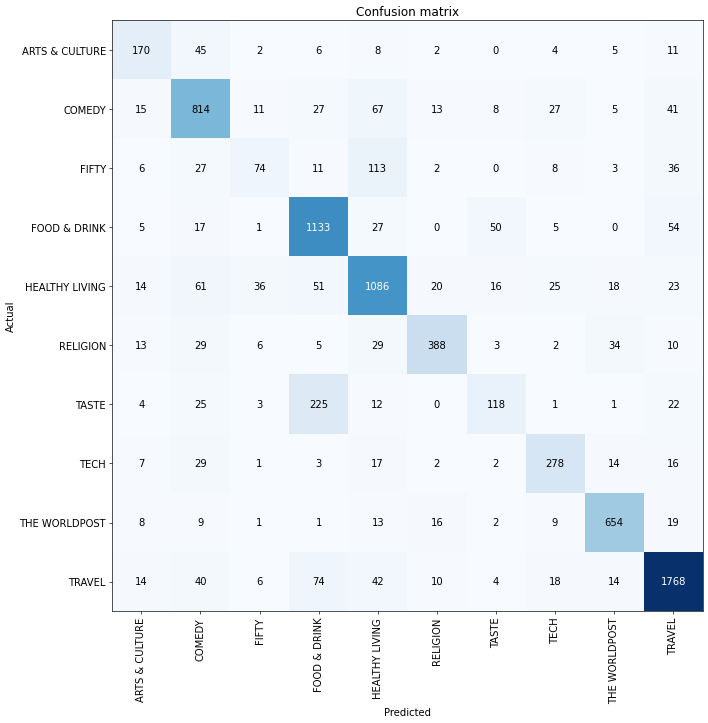

In [18]:
#  What does the confusion matrix look like after a single epoch?
interpretation = ClassificationInterpretation.from_learner( learner )
interpretation.plot_confusion_matrix( figsize = ( 12, 12 ), dpi = 60 )

# Not to bad -- let's push forward and tune a bit more

In [19]:
# Lets do a couple of fine tuning epochs
for i in range( 1 ):
  print( f"\n\nfine tuning iteration #{i+1}" )
  learner.fine_tune( 1, base_lr = 0.02 )



fine tuning iteration #1


/usr/local/lib/python3.10/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/usr/local/lib/python3.10/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


epoch,train_loss,valid_loss,accuracy,time
0,0.840044,0.671091,0.776508,00:52


/usr/local/lib/python3.10/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/usr/local/lib/python3.10/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


epoch,train_loss,valid_loss,accuracy,time
0,0.687843,0.571380,0.808609,00:48


/usr/local/lib/python3.10/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/usr/local/lib/python3.10/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


/usr/local/lib/python3.10/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/usr/local/lib/python3.10/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


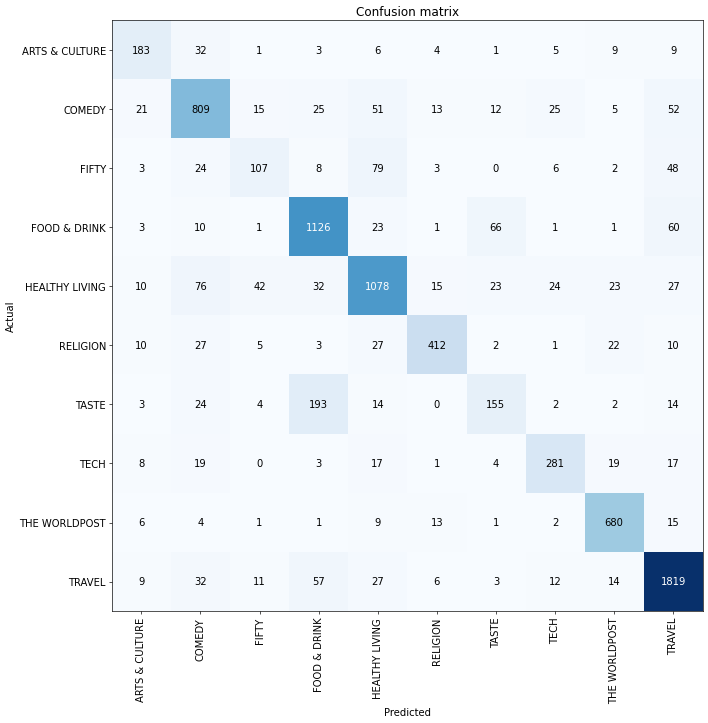

In [20]:
# And finally the confusion matrix
interpretation = ClassificationInterpretation.from_learner( learner )
interpretation.plot_confusion_matrix( figsize = ( 12, 12 ), dpi = 60 )

In [21]:
# Let's finish up by saving the classifier to disk
classifier_path = os.path.join( "gdrive/MyDrive/EAI6010/news_category_classifier" )
learner.export( classifier_path )

In [22]:
# Let's load the model and make a prediction
learner = []
learner = load_learner( classifier_path )
content = "Priceless Picasso painting on exhibit in a supermarket near the beer aisle \n The goal is to make art more accessible for all."
prediction, prediction_possibility, prediction_possibilities = learner.predict( content )
print( f"prediction = {prediction}\n\n" )

prediction = ARTS & CULTURE


